
#  <font color=Blue>Market Basket Analysis</font>
Purpose: Conduct a market basket analysis using the Python programming language. 

Market basket analysis is a data analysis and data mining technique that discovers associations between items. It works by looking for combinations of items that occur together frequently in transactions. Association rules are used to analyze transaction data and are intended to identify strong rules based on the metrics of support, confidence, and lift. 

This document will overview the neccessary steps to conduct a market basket analysis like:

1. Import transaction data from a database
2. Clean and manipulate data with the Pandas library
3. Run a dataset through a machine learning algorithm to find association rules
4. Visualize association rules with various Python libraries






## Input 

The dataset used in this document is sourced from Teradata. 

It contains transactional data from:

- Store #: 710
- Date Range: 7/1/2018 - 7/28/2018
- Columns: TXN_ID, PROD_ID (Product Hierarchy: Class Level)
- Record Count: 365321
- Total Baskets: 52317
- Total Unique Products: 2250

## Algorithm

In order to implement market basket analysis, **Apriori** will be used. Apriori is a popular algorithm for extracting frequent itemsets with applications in association rule learning. The Apriori algorithm has been designed to operate on databases containing transactions, such as purchases by customers of a store. An itemset is considered as "frequent" if it meets a user-specified support threshold. It states: If an itemset is frequent, then all its subsets must also be frequent. The Apriori algorithm eliminates any itemsets that do not meet the user-specified support threshold. Association rule generation is a common task in the mining of frequent patterns. An association rule is an implication expression of the form {*X*} → {*Y*}, where *X* and *Y* are disjoint itemsets. To evaluate the "interest" of such an association rule, different metrics have been developed. The current implementation make use of the confidence and lift metrics.

## Author
Written By: Kyle Rocha

## <font color=Green>Documentation Begins Here:</font>

### Import Libraries

- **Parameter:** A Python script containing the parameters of the program. Contains parameters such as Teradata login information and minimum support threshold.
- **Teradata:** Library used to make a connection to Teradata ODBC.
- **Pandas:** Library used to create and manipulate data structures.
- **MLxtend:** Library of useful tools for the day-to-day data science tasks. This library is used to implement the Apriori algorithm upon our transaction data.
- **Numpy:** Library for large, multi-demensional arrays and matrices. 
- **Matplotlib, NetworkX, and Seaborn:** Libraries used to visualize the outputed association rules. 

In [1]:
#Import Libraries
import parameter as par
import teradata
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

Using the Teradata library, a connection is established to Teradata ODBC.

Parameters are imported using par.

The connection is assigned to the variable session.

In [2]:
#Connect to Teradata 
udaExec = teradata.UdaExec (appName="Market_Basket_Analysis", version="1.0",
        logConsole=False)

session = udaExec.connect(method="odbc", system=par.system,
        username=par.username, password=par.password)

Once the connection is established to Teradata, the query below is executed and assigned to the variable query.

Using Pandas pd.read_sql, the query is loaded into a Pandas dataframe called df_transactions_2018.

In [3]:
#Load the transactional/input data into a Pandas dataframe  
query = """
  select
    a.txn_id,
    c.class_nm as PROD_ID
    
    from      
    dw_dss.txn_FACTS          a
    ,dw_dss.lu_day_merge      b
    ,dw_dss.lu_upc            c 
    
    where   
    a.store_id = 0710
    and a.upc_id                              = c.upc_id
    and a.txn_dte                             = b.d_date
    and b.week_id                            between 201819 and 201822
    and a.upc_id not = 67270610708
    and c.upc_dsc not = 'UNKNOWN'
    and c.class_id not = 758501
    
    and group_id <99            
    group   by 1,2
    """

df_transactions_2018 = pd.read_sql(query,session) 

df_transactions_2018['TXN_ID']= df_transactions_2018['TXN_ID'].astype(np.int64) 

print("Printing Transactions Data Frame--")

print(df_transactions_2018.head(15))

Printing Transactions Data Frame--
           TXN_ID                                      PROD_ID
0   5425071002253                CALIFORNIA TABLE WINE >=1.5LT
1   5425071002253                                   DELI SALSA
2   5425071002253                  FRESH CUT FRUIT CONVENIENCE
3   5425071002253          GRAB AND GO FRESH FRUIT CONVENIENCE
4   5425071002253                                       MANGOS
5   5425071002253    NATIONAL BRAND TRADITIONAL SANDWICH BREAD
6   5426071000000                          CSD <= 24 OZ SINGLE
7   5426071000002                         ROCK STAR RTD ENERGY
8   5426071000015                      DAIRY REFRIGERATED DIPS
9   5426071000015                             FLAVORED CREAMER
10  5426071000015                       INSTANT LIGHT CHARCOAL
11  5426071000015                                LAMB SHOULDER
12  5426071000015      MACARONI SALAD SELF SERVICE DELI SALADS
13  5426071000015              MAINSTREAM REFRIGERATED CHICKEN
14  5426071000015  T

Using Pandas, manipulate df_transactions_2018 by grouping TXN_ID together and applying list to PROD_ID. 

The resulting dataframe will now be grouped by transaction/basket. 

The new dataframe is assigned to df_basket_2018. 

In [4]:
#Manipulate the transaction dataframe into a basket dataframe, reset index
df_basket_2018 = df_transactions_2018.groupby('TXN_ID').PROD_ID.apply(list).reset_index()

print("Printing Basket Data Frame--")

print(df_basket_2018.head(15))

Printing Basket Data Frame--
           TXN_ID                                            PROD_ID
0   5425071002253  [CALIFORNIA TABLE WINE >=1.5LT, DELI SALSA, FR...
1   5426071000000                              [CSD <= 24 OZ SINGLE]
2   5426071000002                             [ROCK STAR RTD ENERGY]
3   5426071000015  [DAIRY REFRIGERATED DIPS, FLAVORED CREAMER, IN...
4   5426071000019  [BANANAS, CANNED BAKED BEANS, CUP MICROWAVE PR...
5   5426071000021  [BANANAS, GLACEAU FLAVORED/FUNCTIONAL WATER, I...
6   5426071000022  [A/O 100% JUICE, CHOCOLATE BARS INSTANT CONSUM...
7   5426071000023                               [REGULAR MAYONNAISE]
8   5426071000024  [GRAB AND GO FRESH FRUIT CONVENIENCE, KIT CONV...
9   5426071000030                                       [CRAFT BEER]
10  5426071000032  [ACCESSORIES ACCESSORIES, CHOCOLATE BARS INSTA...
11  5426071000033                             [ISB BREAKFAST DONUTS]
12  5426071000036  [1CT 0-16OZ ORANGE JUICE, CSD < 12 OZ MP CANS,...
13  5

df_basket_2018 must be converted into a sparse array for memory efficiency purposes.

Using  <font color=red>TransactionEncoder()</font> object, we can transform df_basket_2018 into a sparse array suitable for Apriori. Via the <font color=red>fit</font> method, the TransactionEncoder learns the unique labels in the dataset, and via the <font color=red>transform</font> method, it transforms the input dataset (a Python list of lists aka df_basket_2018) into a one-hot encoded Numpy boolean array. After fitting, the unique column names that correspond to the data array shown below can be accessed via the <font color=red>columns_</font> attribute</font>.

In [5]:
#Transform Pandas dataframe into a sparse Numpy boolean array with TransactionEncoder() to prepare for Apriori algorithm
te = TransactionEncoder()
dset = df_basket_2018.PROD_ID.values
te_ary = te.fit(dset).transform(dset, sparse=True)

print("Printing te_ary--")

print(te_ary)

StringCols = [str(i) for i in te.columns_]

Printing te_ary--
  (0, 1141)	True
  (0, 766)	True
  (0, 527)	True
  (0, 1025)	True
  (0, 294)	True
  (0, 699)	True
  (1, 488)	True
  (2, 1558)	True
  (3, 510)	True
  (3, 912)	True
  (3, 849)	True
  (3, 678)	True
  (3, 1825)	True
  (3, 2131)	True
  (3, 970)	True
  (3, 1007)	True
  (4, 833)	True
  (4, 802)	True
  (4, 1158)	True
  (4, 193)	True
  (4, 1438)	True
  (4, 1521)	True
  (4, 1577)	True
  (4, 2201)	True
  (4, 574)	True
  :	:
  (52314, 1478)	True
  (52314, 931)	True
  (52314, 665)	True
  (52314, 600)	True
  (52314, 806)	True
  (52314, 1318)	True
  (52315, 1003)	True
  (52315, 715)	True
  (52315, 1415)	True
  (52315, 716)	True
  (52315, 262)	True
  (52315, 802)	True
  (52315, 766)	True
  (52315, 1453)	True
  (52315, 1577)	True
  (52315, 1826)	True
  (52315, 224)	True
  (52315, 1638)	True
  (52315, 1688)	True
  (52315, 178)	True
  (52315, 1837)	True
  (52316, 489)	True
  (52316, 1449)	True
  (52316, 490)	True
  (52316, 421)	True


The <font color=red>apriori</font> function expects data in a sparse one-hot encoded Pandas dataframe for memory efficiency.

Generate frequent itemsets with <font color=red>apriori</font> by using aprioriData as input and a minimum support threshold. 

From parameters, the minimum support threshold is set to 0.01 or 1%. The results dataframe returns all items and itemsets with at least a 1% support

**Support:** How popular an itemset is, as measured by the proportion of transactions in which an itemset appears. 

At index 0 of the results dataframe, orange juice appears in 1.9688% of all transactions. 

In [6]:
#Find frequent itemsets through the Apriori algorithm and min_supp. threshold.
aprioriData = pd.SparseDataFrame(te_ary, columns=StringCols, default_fill_value=False)

print("Printing aprioriData--")

print(aprioriData.head(15))

Results = apriori(aprioriData, min_support= par.min_support, use_colnames=True)

print("Printing Frequent Itemsets Generated by Apriori--")

print(Results.head(15))

Printing aprioriData--
    0-3.59OZ CAT FOOD SNACKS/DRINKS  0-5.79LB DOG FOOD DRY  \
0                             False                  False   
1                             False                  False   
2                             False                  False   
3                             False                  False   
4                             False                  False   
5                             False                  False   
6                             False                  False   
7                             False                  False   
8                             False                  False   
9                             False                  False   
10                            False                  False   
11                            False                  False   
12                            False                  False   
13                            False                  False   
14                            False            

Printing Frequent Itemsets Generated by Apriori--
     support                                     itemsets
0   0.019688                 (1CT 16.1-64OZ ORANGE JUICE)
1   0.011411                            (ADULT NOVELTIES)
2   0.038897                     (ALL FAMILY COLD CEREAL)
3   0.047098                       (ALL FAMILY NOVELTIES)
4   0.010991        (ALL OTHER FLAVORED/FUNCTIONAL WATER)
5   0.021981       (ALMOND/NUT HEALTH & MILK SUBSTITUTES)
6   0.010169                               (ASIAN SAUCES)
7   0.023319                              (BACON REGULAR)
8   0.126536                                    (BANANAS)
9   0.025403                          (BEEF LOIN, CHOICE)
10  0.011067                           (BEEF RIB, CHOICE)
11  0.031730                               (BELL PEPPERS)
12  0.026989                (BLENDED REFRIGERATED YOGURT)
13  0.025116                   (BLENDS CONVENIENCE SALAD)
14  0.012577  (BRANDED NATURAL/ORGANIC/PREMIUM GRND BEEF)


The <font color=red>association_rules</font> takes dataframes of frequent itemsets as produced by <font color=red>apriori</font> and generates association rules. <font color=red>association_rules</font> allows users to specify a metric of interest (confidence or lift) and the according threshold. 

**Confidence:** The probability of seeing the consequent in a transaction given that it also contains the antecedent.

**Lift:** The ratio of observed support to that expected if the antecedent and consequent were statistically independent. 

The rules dataframe generates association rules with metrics to evaluate if the rule is of interest.

At index 0 of the rules dataframe, (BANANAS) --> (ALL FAMILY COLD CEREAL) is an exmaple of an association rule with metrics.

In [7]:
#Generate association rules from frequent itemsets using a minimum confidence or lift threshold
rules = association_rules(Results, metric=par.metric, min_threshold=par.min_threshold)

#Add store number and rename index of rules dataframe 
rules['store_id'] = par.Store_ID
rules.index.names = ['Rule_Nbr']

print("Printing Association Rules Data Frame--")
 
print(rules)

Printing Association Rules Data Frame--
                                          antecedents  \
Rule_Nbr                                                
0                            (ALL FAMILY COLD CEREAL)   
1                                           (BANANAS)   
2                              (ALL FAMILY NOVELTIES)   
3                                           (BANANAS)   
4                                         (CUCUMBERS)   
5                                           (BANANAS)   
6                                    (DELI BULK MEAT)   
7                                           (BANANAS)   
8                                  (FLAVORED CREAMER)   
9                                           (BANANAS)   
10              (GRAB AND GO FRESH FRUIT CONVENIENCE)   
11                                          (BANANAS)   
12                                     (HASS AVOCADO)   
13                                          (BANANAS)   
14                            (KIT CONVENIENCE S

**Seaborn Scatter Plot Visualization**

Each point on the scatter represents an association rule.

The X and Y axis are the association rule metrics values.  

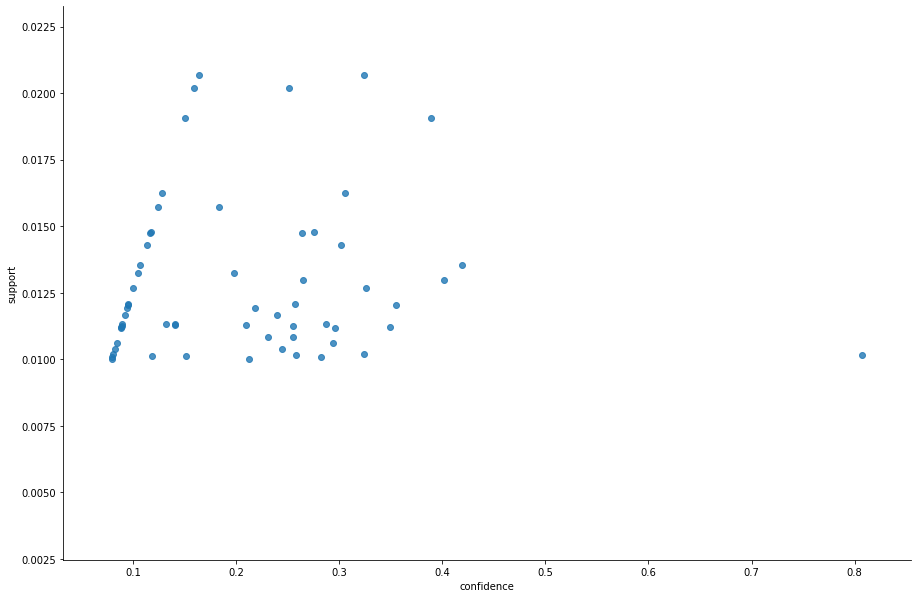

In [8]:
sns.lmplot(data=rules, x='confidence', y='support', fit_reg=False)

plt.gcf().set_size_inches(15,9);

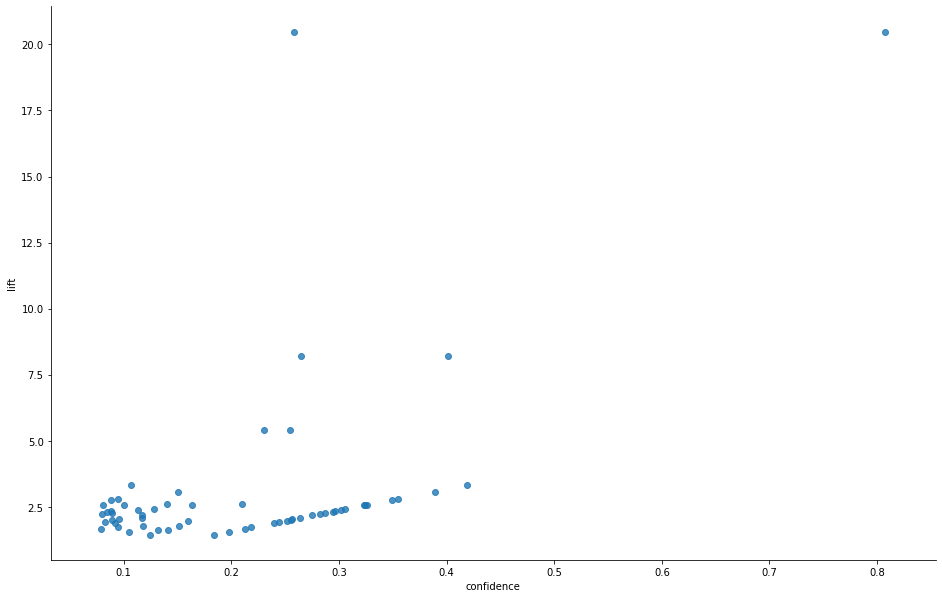

In [10]:
sns.lmplot(data=rules, x='confidence', y='lift', fit_reg=False)

plt.gcf().set_size_inches(15,9);

**NetworkX Association Rule Network Visualization**

The yellow node with R0 identifies one association rule, and it will always have an incoming and outgoing arrow. Incoming arrows will represent antecedants and the outgoing arrows will represent consequents. 

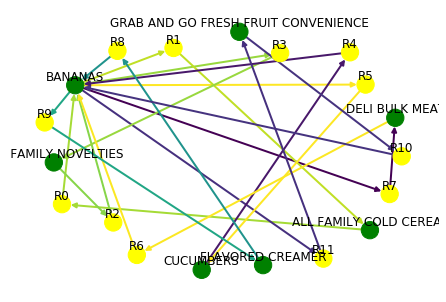

In [26]:
def draw_graph(rules, rules_to_show):  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:=
            color_map.append('yellow')
       else:
            color_map.append('green')       

   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=10, with_labels=False)            
   
  for p in pos:  
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show
  
draw_graph(rules,12)